Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti
Label distribution: label
4    12678
3     9871
2     5742
0     3065
1     2987
Name: count, dtype: int64
Cleaning text...
Training samples: 11000, Validation samples: 9000
Tokenizing...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


C:\Users\Leandro Mendez\anaconda3\Lib\site-packages\transformers\utils\generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
C:\Users\Leandro Mendez\anaconda3\Lib\site-packages\transformers\utils\generic.py:255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)


Step,Training Loss
100,1.453400
200,1.236900
300,1.241600
400,1.192900
500,1.215400
600,1.185900
700,1.153700
800,1.002500
900,0.974600
1000,1.063600


Training complete.

Running final evaluation...


{'eval_loss': 1.8217440843582153, 'eval_accuracy': 0.5436666666666666, 'eval_off_by_one_accuracy': 0.9191111111111111, 'eval_runtime': 7.6691, 'eval_samples_per_second': 1173.548, 'eval_steps_per_second': 36.771, 'epoch': 5.0}


C:\Users\Leandro Mendez\anaconda3\Lib\site-packages\transformers\utils\generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
C:\Users\Leandro Mendez\anaconda3\Lib\site-packages\transformers\utils\generic.py:255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)


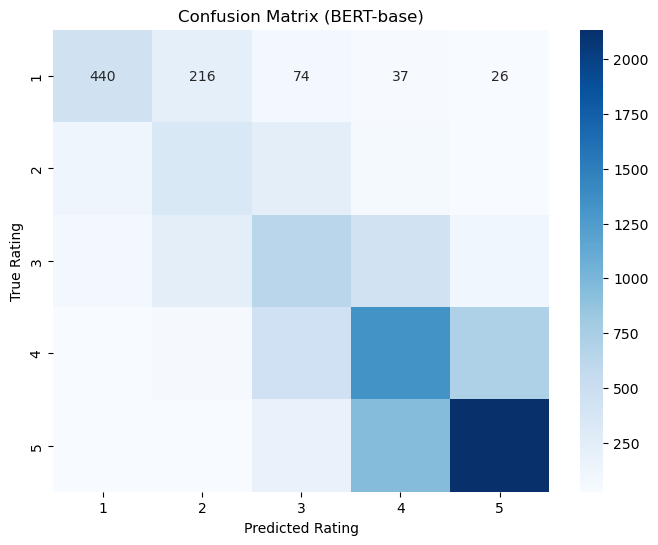

Detailed classification report:

              precision    recall  f1-score   support

           1      0.625     0.555     0.588       793
           2      0.388     0.431     0.409       800
           3      0.402     0.432     0.417      1488
           4      0.474     0.513     0.493      2595
           5      0.711     0.642     0.675      3324

    accuracy                          0.544      9000
   macro avg      0.520     0.515     0.516      9000
weighted avg      0.555     0.544     0.548      9000

Model saved to ./bert_base_hotel_reviews


In [10]:
# ==========================================================
# Imports
# ==========================================================
import os
import pandas as pd
import numpy as np
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments
)
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss

# ==========================================================
# Check GPU
# ==========================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# ==========================================================
# Load and clean data
# ==========================================================
df = pd.read_csv("7282_1_dedupe_cleaned.csv")
df = df[['reviews.text', 'reviews.rating']].dropna()
df = df[df['reviews.text'].str.strip() != '']

df['rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce').astype(int)
df = df.dropna(subset=['rating'])
df = df[(df['rating'] >= 1) & (df['rating'] <= 5)]
df['label'] = df['rating'] - 1

print("Label distribution:", df['label'].value_counts())

# ==========================================================
# Text cleaning
# ==========================================================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\']', '', text)
    return re.sub(r'\s+', ' ', text).strip()

print("Cleaning text...")
df['clean_text'] = df['reviews.text'].apply(clean_text)

# ==========================================================
# Optional: Limit dataset size
# ==========================================================
MAX_SAMPLES = 20000
if len(df) > MAX_SAMPLES:
    df = df.sample(n=MAX_SAMPLES, random_state=42)

# ==========================================================
# Split train/validation (~9k validation, stratified)
# ==========================================================
VAL_SAMPLES = 9000
train_frac = 1 - (VAL_SAMPLES / len(df))

X_train, X_val, y_train, y_val = train_test_split(
    df['clean_text'].tolist(),
    df['label'].tolist(),
    train_size=train_frac,
    random_state=42,
    stratify=df['label']
)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# ==========================================================
# Tokenization
# ==========================================================
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(texts):
    return tokenizer(
        texts,
        truncation=True,
        max_length=128,
        padding=False
    )

print("Tokenizing...")
train_enc = tokenize_data(X_train)
val_enc = tokenize_data(X_val)

# ==========================================================
# Dataset Class
# ==========================================================
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx], dtype=torch.long) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = ReviewDataset(train_enc, y_train)
val_dataset   = ReviewDataset(val_enc, y_val)

# ==========================================================
# Class weights for loss
# ==========================================================
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# ==========================================================
# Subclass Trainer to apply weighted loss
# ==========================================================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ==========================================================
# Model
# ==========================================================
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5
)
model.to(device)
model.gradient_checkpointing_enable()

# ==========================================================
# Metrics
# ==========================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    off_by_one = np.mean(np.abs(labels - preds) <= 1)
    return {
        "accuracy": acc,
        "off_by_one_accuracy": off_by_one
    }

# ==========================================================
# Data collator
# ==========================================================
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ==========================================================
# Training Arguments
# ==========================================================
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    bf16=torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8,
    optim="adamw_torch",
    gradient_checkpointing=True,
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="no",
    save_strategy="no",
    report_to=[]
)

# ==========================================================
# Trainer
# ==========================================================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# ==========================================================
# Train
# ==========================================================
print("Starting training...")
trainer.train()
print("Training complete.")

# ==========================================================
# Evaluation
# ==========================================================
print("\nRunning final evaluation...")
metrics = trainer.evaluate()
print(metrics)

preds = trainer.predict(val_dataset)
y_pred = np.argmax(preds.predictions, axis=-1)

# ==========================================================
# Confusion Matrix
# ==========================================================
labels = [1, 2, 3, 4, 5]
cm = confusion_matrix(np.array(y_val) + 1, y_pred + 1, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.title("Confusion Matrix (BERT-base)")
plt.show()

# ==========================================================
# Classification Report
# ==========================================================
y_true = np.array(y_val) + 1
y_pred_labels = y_pred + 1

report = classification_report(
    y_true,
    y_pred_labels,
    labels=[1, 2, 3, 4, 5],
    target_names=[str(i) for i in range(1, 6)],
    digits=3
)
print("Detailed classification report:\n")
print(report)

# ==========================================================
# Save Model
# ==========================================================
save_path = "./bert_base_hotel_reviews"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model saved to {save_path}")


rating
1    1762
2    1777
3    3307
4    5766
5    7388
Name: count, dtype: int64
label
0    1762
1    1777
2    3307
3    5766
4    7388
Name: count, dtype: int64


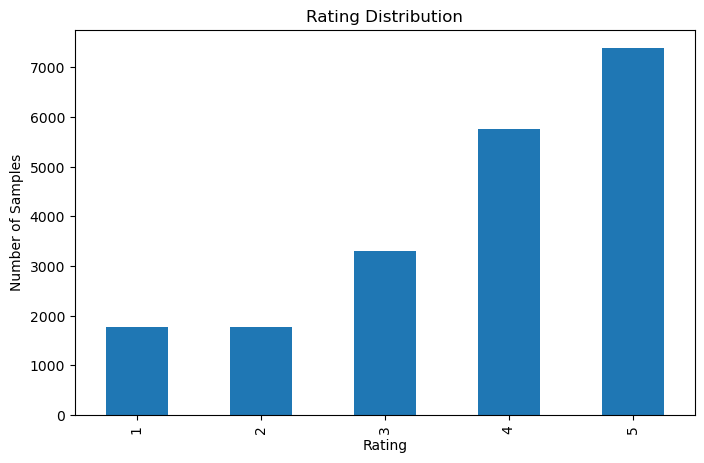

rating
1     8.810
2     8.885
3    16.535
4    28.830
5    36.940
Name: count, dtype: float64

In [13]:
# Count the number of samples per rating
rating_counts = df['rating'].value_counts().sort_index()
print(rating_counts)

# Or for your 0–4 labels
label_counts = df['label'].value_counts().sort_index()
print(label_counts)

# Optionally, visualize with a bar chart
import matplotlib.pyplot as plt

rating_counts.plot(kind='bar', figsize=(8,5), title="Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Samples")
plt.show()
rating_counts / len(df) * 100
